### DCGAN 
A GAN constsit of two adversaries , generator and discriminator batteling eachother. The generator converts random noise into data that looks like sample from original dataset and discriminator tries to predict whether the observation comes from original dataset or not. 

In [3]:
%load_ext autoreload 
%autoreload 2 
import numpy as np 
import matplotlib.pyplot as plt 

import tensorflow as tf 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

from utils import display, sample_batch

2023-07-19 03:59:36.521339: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 03:59:36.670184: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-19 03:59:36.730413: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-19 03:59:37.350481: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

1 Physical GPUs, 1 Logical GPUs


2023-07-19 03:59:38.421166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 03:59:38.458059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 03:59:38.458216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 03:59:38.459680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

### PARAMETERS

In [4]:
IMAGE_SIZE = 64 
CHANNELS = 1 
BATCH_SIZE = 128 
Z_DIM = 100 
EPOCHS = 300 
LOAD_MODEL = False 
ADAM_BETA_1 = 0.5 
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1 

### PREPARE THE DATA 

In [6]:
train_data = utils.image_dataset_from_directory(
    "../data/lego-brick-images/dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE, 
    shuffle=True,
    seed = 42,
    interpolation="bilinear",
)

Found 40000 files belonging to 1 classes.


In [7]:
#we use [-1,1] for rescaling data so that we can use tanh activation function on the final layer of the generator , which provides strong
#gradients than the sigmoid function
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img,"float32")-127.5) / 127.5
    return img 
train = train_data.map(lambda x: preprocess(x)

In [8]:
train_sample = sample_batch(train)

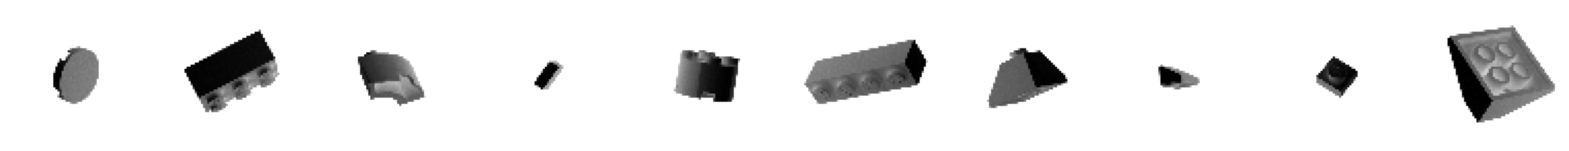

In [9]:
display(train_sample)

### The Discriminator

The goal is to predict if the image is real or fake  which is supervised image classification problem 

In [11]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS))

x = layers.Conv2D(64,kernel_size=4, strides=2, padding="same",use_bias=False)(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2,padding="same", use_bias=False)(x)

x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256,kernel_size=4, strides=2, padding="same", use_bias=False)(x)

x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias=False)(x)

x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x)
discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                           

### The Generator 
The generator will be converting a vector from multivariate normal distribution to the image of the same size contained in the original training data

In [12]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1,1,Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False)(x)

x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)

x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides = 2, padding="same", use_bias=False
)(x)

x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)

x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides= 2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x)

generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_6 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 128)        1048

In [ ]:
class DCGAN(models.Model):
    def __init__(self,